In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

In [2]:
tqdm.pandas()

In [3]:
def reduce_mem_usage(df: pd.DataFrame) -> pd.DataFrame:
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype.name
        if col_type not in ['object', 'category', 'datetime64[ns, UTC]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
import kagglehub

path = kagglehub.dataset_download("bwandowando/spotify-songs-with-attributes-and-lyrics")

print("Path to dataset files:", path)

100%|██████████| 894M/894M [00:46<00:00, 20.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bwandowando/spotify-songs-with-attributes-and-lyrics/versions/18


In [ ]:
attr_data = pd.read_csv(
    "/root/.cache/kagglehub/datasets/bwandowando/spotify-songs-with-attributes-and-lyrics/"
    "versions/18/songs_with_attributes_and_lyrics.csv/songs_with_attributes_and_lyrics.csv"
)

In [ ]:
attr_data.shape

(955320, 17)

In [ ]:
attr_data = reduce_mem_usage(attr_data)

Memory usage of dataframe is 123.90 MB
Memory usage after optimization is: 71.06 MB
Decreased by 42.6%


In [ ]:
attr_data.id.nunique()

955320

In [ ]:
attr_data.isna().sum()

,0
id,0
name,11
album_name,569763
artists,2
danceability,0
energy,0
key,0
loudness,0
mode,0
speechiness,0


In [ ]:
data = attr_data.dropna(subset=["name", "artists", "lyrics"])

In [ ]:
data = data.drop("album_name", axis=1)

In [ ]:
del attr_data

In [ ]:
data.artists = data.artists.apply(lambda x: ", ".join(eval(x)) if "['" in x and "']" in x else x)

In [ ]:
data.memory_usage().sum() / 1024 ** 2

71.06121826171875

In [ ]:
data = reduce_mem_usage(data)

Memory usage of dataframe is 71.06 MB
Memory usage after optimization is: 71.06 MB
Decreased by 0.0%


In [ ]:
data.dtypes

,0
id,object
name,object
artists,object
danceability,float16
energy,float16
key,object
loudness,float16
mode,object
speechiness,float16
acousticness,float16


In [ ]:
def process_text(text: str):
    return " ".join("".join([i if i.isalpha() else " " for i in text]).lower().split())

In [ ]:
data["lyrics"] = data.lyrics.progress_map(process_text)

  0%|          | 0/955296 [00:00<?, ?it/s]

In [ ]:
data["lyrics"] = data.lyrics.progress_map(simple_preprocess)

  0%|          | 0/955296 [00:00<?, ?it/s]

In [ ]:
model = Word2Vec(sentences=data.lyrics.values, vector_size=100, window=5, min_count=1, workers=20, sg=0)

Words similar to 'word':
prayer: 0.6817
words: 0.6610
syllable: 0.6456
language: 0.6310
single: 0.6040


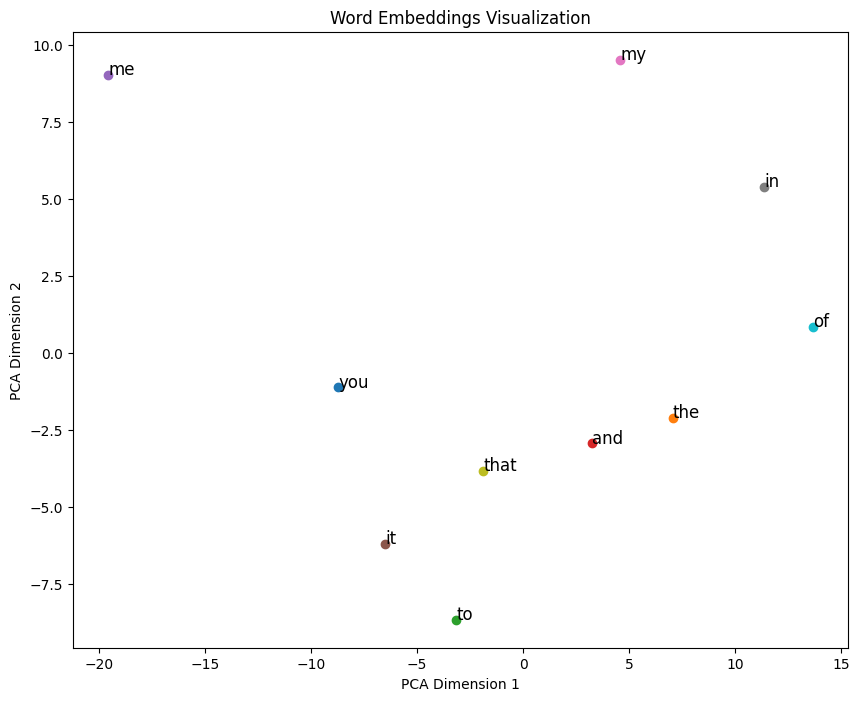

In [ ]:
word_vectors = model.wv

similar_words = word_vectors.most_similar("word", topn=5)
print("Words similar to 'word':")
for word, similarity in similar_words:
    print(f"{word}: {similarity:.4f}")


def plot_word_embeddings(word_vectors, words_to_plot):
    vectors = [word_vectors[word] for word in words_to_plot]
    pca = PCA(n_components=2)
    reduced_vectors = pca.fit_transform(vectors)

    plt.figure(figsize=(10, 8))
    for word, vector in zip(words_to_plot, reduced_vectors):
        plt.scatter(vector[0], vector[1])
        plt.text(vector[0] + 0.01, vector[1] + 0.01, word, fontsize=12)
    plt.title("Word Embeddings Visualization")
    plt.xlabel("PCA Dimension 1")
    plt.ylabel("PCA Dimension 2")
    plt.show()


words_to_visualize = list(word_vectors.index_to_key)[:10]
plot_word_embeddings(word_vectors, words_to_visualize)

In [ ]:
model.save("word2vec_lyrics.model")

In [ ]:
model.vector_size

100

In [ ]:
len(model.wv)

2101450

In [ ]:
similar_words = word_vectors.most_similar("man", topn=5)
print("Words similar to 'word':")
for word, similarity in similar_words:
    print(f"{word}: {similarity:.4f}")

Words similar to 'word':
boy: 0.8401
woman: 0.8120
that: 0.7445
girl: 0.7388
he: 0.7345


In [ ]:
def sentence_to_vector(words, model):
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if not word_vectors:
        return None
    return sum(word_vectors) / len(word_vectors)

In [ ]:
vectors = data.lyrics.progress_map(lambda x: sentence_to_vector(x, model))

  0%|          | 0/955296 [00:00<?, ?it/s]

In [ ]:
data = data.loc[data.lyrics.apply(lambda x: len(x) != 0)]

In [ ]:
data.shape

(955278, 16)

In [ ]:
np.array(vectors).shape

(955278, 100)

In [ ]:
data = data.reset_index()
data[list(range(100))] = np.array(vectors)

<ipython-input-196-bd7152917094>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[list(range(100))] = np.array(vectors)
<ipython-input-196-bd7152917094>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[list(range(100))] = np.array(vectors)
<ipython-input-196-bd7152917094>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, u

In [ ]:
data.isna().sum().sum()

0

In [ ]:
data = reduce_mem_usage(data)

Memory usage of dataframe is 435.47 MB
Memory usage after optimization is: 249.62 MB
Decreased by 42.7%


In [ ]:
import faiss
from sklearn.preprocessing import normalize

item_embeddings = data[list(range(100))].values
test_vector = sentence_to_vector("i m just a freak".split(), model)


In [ ]:
item_embeddings = normalize(item_embeddings, axis=1)
test_vector = normalize(test_vector.reshape(1, -1), axis=1)

dimension = item_embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)
index.add(item_embeddings)

k = 10
distances, indices = index.search(test_vector, k)

print("Nearests neighbors indexes:", indices[0])
print("Similarity:", distances[0])


Индексы ближайших соседей: [ 51115 274289 274276 742640 274290 516568 688115 274385 872821 742756]
Сходства: [0.9563412  0.9515437  0.9515437  0.94510216 0.9423716  0.93059605
 0.9304216  0.92952377 0.928706   0.92846197]


In [4]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = data.drop("lyrics", axis=1)

In [ ]:
data.to_csv("./drive/MyDrive/vectors_final_data.csv", index=False)

In [ ]:
data = data.drop("index", axis=1)

In [ ]:
data.sample(5)

,id,name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,...,90,91,92,93,94,95,96,97,98,99
851098,0hGuuLs6mg1U3D6uDebNhr,Verdeckte Aktion - Bonus-Mix,City,0.607910,0.882812,0,-6.019531,1,0.063110,0.151001,...,-0.181885,-0.981934,-0.220581,1.225586,0.965820,-0.013100,0.012695,0.552734,-0.059296,1.170898
279594,5M39ClRYJKRB2vJBFLf904,Fuiste a Acapulco,Los Apson,0.645020,0.705078,0,-6.789062,1,0.041687,0.816895,...,-1.917969,-0.472900,2.156250,0.536133,2.410156,-1.541016,0.656250,0.995117,2.003906,-0.779785
923433,47spz8LqRfopFdO7GsQ7V8,he's not you,VÉRITÉ,0.806152,0.513184,0,-7.156250,1,0.050995,0.025208,...,3.115234,-0.937500,-1.301758,2.015625,0.954590,3.232422,-1.834961,-0.641113,-3.185547,-1.229492
797534,0Uar43NSoMj9e0WatGjFsl,The Ugliest House On The Block,Beth Hart,0.633789,0.750977,11,-7.480469,1,0.042603,0.098816,...,3.164062,-0.705078,-0.901367,1.892578,-0.159424,2.882812,-1.147461,-0.267334,-2.937500,-0.716797
703908,4ZrftZyqw3oxn2tWb3sCni,Slow Motion,Kittie,0.239014,0.971191,7,-3.171875,0,0.101990,0.001310,...,3.853516,-0.837891,-2.160156,3.001953,0.744141,3.562500,-1.253906,-0.626953,-3.482422,-0.551270


In [48]:
data = pd.read_csv("./drive/MyDrive/vectors_final_data.csv")

In [49]:
data = reduce_mem_usage(data)

Memory usage of dataframe is 838.14 MB
Memory usage after optimization is: 238.69 MB
Decreased by 71.5%


In [50]:
data.columns

Index(['id', 'name', 'artists', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness',
       ...
       '90', '91', '92', '93', '94', '95', '96', '97', '98', '99'],
      dtype='object', length=115)

In [51]:
data.dtypes.head(10)

,0
id,object
name,object
artists,object
danceability,float16
energy,float16
key,object
loudness,float16
mode,object
speechiness,float16
acousticness,float16


In [52]:
data.key.unique()

array(['7', '5', '2', '1', '9', '0', '4', 'F', '6', '8', '7.0', 'C#',
       '8.0', 'C', '3', 'A#', '10.0', '11', 'F#', 'A', 'D#', '11.0', '10',
       '1.0', 'E', '6.0', 'G', '0.0', 'D', '2.0', '5.0', 'B', '9.0',
       '4.0', 'G#', '3.0'], dtype=object)

In [53]:
data["mode"].unique()

array(['1', '0', 'Major', '1.0', 'Minor', '0.0'], dtype=object)

In [54]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data["key"] = le.fit_transform(data["key"])

In [55]:
data["mode"] = data["mode"].replace({"Major": 1, "Minor": 0})

In [56]:
import pickle

In [57]:
with open("./drive/MyDrive/le_key.pkl", "wb") as f:
    pickle.dump(le, f)

In [58]:
data["mode"] = data["mode"].astype(float)

In [59]:
data = reduce_mem_usage(data)

Memory usage of dataframe is 238.69 MB
Memory usage after optimization is: 226.85 MB
Decreased by 5.0%


In [60]:
data.shape

(955278, 115)

In [62]:
from sklearn.neighbors import NearestNeighbors

embeddings = data.loc[:, '0':'99'].to_numpy()

nn_model = NearestNeighbors(n_neighbors=31, algorithm='auto', metric='euclidean')
nn_model.fit(embeddings)

query_indices = [0, 1]
queries = embeddings[query_indices]

distances, indices = nn_model.kneighbors(queries)

for i, query_idx in enumerate(query_indices):
    print(f"For song '{data.iloc[query_idx]['name']}' similar is:")
    for neighbor_idx in indices[i][1:]:
        neighbor = data.iloc[neighbor_idx]
        print(f"  - {neighbor['name']} ({neighbor['artists']})")


For song '!' similar is:
  - High School (Nicki Minaj, Lil Wayne)
  - High School (Nicki Minaj;Lil Wayne)
  - Mona Lisa (feat. Kendrick Lamar) (Lil Wayne)
  - Episode (E-40)
  - You Said (feat. Quavo) (Young Thug, Quavo)
  - I'm Sprung 2 (T-Pain)
  - I'm Sprung 2 (feat. YoungBloodZ & Trick Daddy) (T-Pain)
  - Fuck You (Dr. Dre)
  - Fuck You (Dr. Dre, Devin The Dude, Snoop Dogg)
  - Wishing Remix (feat. Chris Brown, Fabolous, Trey Songz, Jhene Aiko & Tory Lanez) (DJ Drama)
  - Wishing Remix (feat. Chris Brown, Fabolous, Trey Songz, Jhene Aiko & Tory Lanez) (DJ Drama, Chris Brown, Jhené Aiko, Tory Lanez, Fabolous, Trey Songz)
  - Born Again (Suga Free)
  - Versatile (Kodak Black)
  - Versatile (Kodak Black)
  - Versatile (Kodak Black)
  - I.O.U. (Inspectah Deck)
  - Hustla's Wife (C-Murder, 50/50 Twin)
  - Try Again Tomorrow (J. Stalin)
  - Bust It Baby Part 2 (feat. Ne-Yo ) (Plies)
  - Freak (Frequency) (Indigo, the Rapper)
  - I'm a Flirt Remix (R. Kelly)
  - I'm a Flirt Remix (feat. T

In [63]:
with open("./drive/MyDrive/nn_model.pkl", "wb") as f:
    pickle.dump(nn_model, f)